<a href="https://colab.research.google.com/github/Brent-Morrison/Coursera_Capstone/blob/master/applied_data_science_capstone_4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applied Data Science Capstone Project - Paycheck Protection Program loans**

# Introduction

This project will seek to determine if political persuasion influences utilisation of government assistance.

We will investigate the uptake of loans granted under the Small Business Administration Paycheck Protection Program ("SBA-PPP") in the United States.

The SBA-PPP was set up by the US Treasury to provide funding to businesses impacted by the COVID-19 pandemic.

The outcome of this analysis will be of interest to social scientists studying the impact of political persuasion on behaviours of businesses in the United States.  

The idea for this project came after reading a number of articles pointing out inconsistencies in an organisations beliefs and actions in relation to government assistance.  These two articles ([In sign of the times, Ayn Rand Institute approved for PPP loan](https://www.reuters.com/article/us-health-coronavirus-ppp-ayn-rand/in-sign-of-the-times-ayn-rand-institute-approved-for-ppp-loan-idUSKBN248026), and [Vocal Opponents Of Federal Spending Took PPP Loans](https://www.forbes.com/sites/andrewsolender/2020/07/06/vocal-opponents-of-federal-spending-took-ppp-loans-including-ayn-rand-institute-grover-norquist-group/#7c2ad6703d53) ), highlight what the authors see as hypocritical behaviour.

These examples represent individual data points, and in all likelihood are called out for their ability to generate headlines.

A more thorough analysis will use granular data, that covering a broad population of firms, to answer the question posed above.  Posing that question in a slightly different way.  Are those who we would expect to be opposed to government intervention, less likely to accept government assistance? 

# Data

Determining if political persuasion influences uptake of loans requires us to do three things:
1. Quantify loan uptake
2. Assess political persuasion
3. Identify and hold other characteristics constant

The data sources that will allow us to do this are outlined below.

### Loan uptake
Data on loans granted under the Small Business Administration Paycheck Protection Program ("SBA-PPP") has been made available at the U.S Treasury [website](https://home.treasury.gov/policy-issues/cares-act/assistance-for-small-businesses/sba-paycheck-protection-program-loan-level-data).  This data set contains records for each loan recipient along with attributes such as geographical location, industry membership and business type.

### Political persuasion
We will assess political persuasion based on electoral results data.  Our source for this data is the [MIT Election Data and Science lab](https://electionlab.mit.edu/data).  This organisation has published numerous election results datasets to [Github](https://github.com/MEDSL).

### Confounding characteristics
The characteristics held constant will be a combination of demographic and industry attributes. Demographic data will be sourced from US census data via the [uszipcode](https://uszipcode.readthedocs.io/index.html) python library.  This library aggregates geographic, demographic, employment and education data.  

**Foursquare** data will be used to assess the type of region or neighbourhood.  This will be done using the quantity and type of businesses in specific geographical regions.



# Data source examples

The code blocks below provide examples of the data sources mentioned above.

In [1]:
# Required libraries
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import MinMaxScaler
import requests
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The **SBA-PPP** data has been downloaded from the US Department of the Treasury website to my google drive folder.  This data was downloaded 15th July 2020.

In [2]:
# Mount Google Drive to Collaboratory

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#ppp_raw = pd.read_csv('gdrive/My Drive/PPP_Data_150k_plus.csv',chunksize=100000)
#ppp_raw[ppp_raw['State'] == 'IL'].head()

Unfortunately the file is quite large and reading from google drive has proven unreliable.  The file has therefore been saved to Github, with a filter applied leaving only the states of Missouri and Illinois.  

Below is a sample of this data.

In [4]:
ppp_raw = pd.read_csv('https://raw.githubusercontent.com/Brent-Morrison/Coursera_Capstone/master/PPP_Data_150k_plus_MOIL.csv')
ppp_raw[ppp_raw['State'] == 'IL'].head()

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
0,a $5-10 million,3D EXHIBITS INC.,ALBION AVE,SCHAUMBURG,IL,60193,561920.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,187.0,43955,"Village Bank and Trust, National Association",IL - 08
1,a $5-10 million,A M CASTLE AND CO,1420 KENSINGTON RD Suite 220,OAK BROOK,IL,60523,423510.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,0.0,04/27/2020,"PNC Bank, National Association",IL - 05
2,a $5-10 million,"AARETE, INC.",200 E. Randolph Street Suite 3010,CHICAGO,IL,60601,541611.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,270.0,44047,BMO Harris Bank National Association,IL - 07
3,a $5-10 million,"ABCOM TECHNOLOGY GROUP, INC.",1456 NORWOOD AVE,ITASCA,IL,60143,561920.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,448.0,44016,Western Alliance Bank,IL - 08
4,a $5-10 million,ACCURATE PERSONNEL LLC,33 S ROSELLE RD,SCHAUMBURG,IL,60193,561320.0,Limited Liability Company(LLC),Unanswered,Male Owned,Non-Veteran,NaN,500.0,44047,"Schaumburg Bank & Trust Company, National Asso...",IL - 08


**MIT Election Data and Science lab** github data.

Below is a sample of this data.

In [5]:
# https://electionlab.mit.edu/data
elctn_county = pd.read_csv('https://raw.githubusercontent.com/MEDSL/2018-elections-official/master/county_2018.csv', encoding = 'ISO-8859-1')
elctn_county[elctn_county['state_po'] == 'IL'].head()

,year,state,state_po,state_fips,state_cen,state_ic,county,office,district,stage,special,rank,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
54580,2018,Illinois,IL,17,33,21,Adams,Attorney General,statewide,gen,False,NaN,Bubba Harsy,libertarian,False,total,597.0,4548409.0,False,20190430
54581,2018,Illinois,IL,17,33,21,Adams,Attorney General,statewide,gen,False,NaN,Erika Harold,republican,False,total,17910.0,4548409.0,False,20190430
54582,2018,Illinois,IL,17,33,21,Adams,Attorney General,statewide,gen,False,NaN,Kwame Raoul,democrat,False,total,5748.0,4548409.0,False,20190430
54583,2018,Illinois,IL,17,33,21,Adams,Comptroller,statewide,gen,False,NaN,Claire Ball,libertarian,False,total,730.0,4535759.0,False,20190430
54584,2018,Illinois,IL,17,33,21,Adams,Comptroller,statewide,gen,False,NaN,Darlene Senger,republican,False,total,15853.0,4535759.0,False,20190430


**Demographic data** is sourced using the [uszipcode](https://uszipcode.readthedocs.io/index.html) python library.

In [6]:
!pip install uszipcode

In [7]:
from uszipcode import SearchEngine, SimpleZipcode

Sample data outputof the `uszipcode` database.

In [8]:
search = SearchEngine(simple_zipcode=True)
zipcode = search.by_zipcode('60193')
zipcode

SimpleZipcode(zipcode='60193', zipcode_type='Standard', major_city='Schaumburg', post_office_city='Schaumburg, IL', common_city_list=['Schaumburg'], county='Cook County', state='IL', lat=42.01, lng=-88.09, timezone='Central', radius_in_miles=4.0, area_code_list=['224', '312', '630', '708', '847'], population=39188, population_density=4289.0, land_area_in_sqmi=9.14, water_area_in_sqmi=0.03, housing_units=16649, occupied_housing_units=16019, median_home_value=257100, median_household_income=72939, bounds_west=-88.154324, bounds_east=-88.031254, bounds_north=42.029954, bounds_south=41.988685)

**Foursquare** data for information on individual neighbourhoods.

In [9]:
# Foursquare credentials
CLIENT_ID='0M35HSSAZ1L2QPGP5LAKSPMBUUDTERESBKXLNZRQMUCEVJYS'
CLIENT_SECRET='QWIGICNR1KXB3RU5Y5LRJFH03RANUYOVRKNTUTO0KCONHAGQ'
VERSION='20200623'
LIMIT=100

In [10]:
# Function for querying Foursquare
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        # Alternate approach due to KeyError on "groups"
        results = requests.get(url).json()["response"].get('groups')[0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        # Prevent disconnect
        time.sleep(0.05)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Zip Latitude', 
                  'Zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Sample output of the Foursquare api

In [11]:
# Example data
schaumburg = getNearbyVenues(
    names=['Schaumburg'],
    latitudes=[42.01],
    longitudes=[-88.09]
  )
schaumburg.head()

,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Schaumburg,42.01,-88.09,Sue Garcia Fitness,42.01383,-88.092864,Gym / Fitness Center


# Methodology  

Our aim is to assess the impact of political persuasion or ideology on the use of government financial assistance. To this end we will narrow our focus to two states at opposing ends of the political spectrum.

[This](https://www.270towin.com/same-since-electoral-maps/) website contains visualisations of state level electoral results over varying time periods.  Missouri and Illinois have voted Republican and Democrat respectively, on a consistent basis over the past 20 years.   Missouri and Illinois are neighbours and therefore are expected to have similar industries and economies.  This is important to our analysis as these are the type of characteristics we wish to control for.

For Missouri and Illinois, we will gather characteristics at zipcode level, and group zipcodes into similar regions.  These regions will be agnostic with respect to political persuasion and loan uptake.

For example, we may find zipcodes in both states that are low population density, high manufacturing industry density, medium income and high density of leisure venues.  This would constitute one group.  We can then assess the political persuasion of each zipcode in this group from electoral data, and finally determine if this results in differing level of loan uptake.  

In summary, the rates of loan uptake will be assessed by comparing the count and value of loans issued by geographical regions known to be of differing political persuasion.  In performing this assessment, confounding characteristics will be isolated and held constant.

### We start by exploring the **SBA-PPP loan** data.  

Unique zipcodes for Missouri and Illinois

In [12]:
print('Count of unique zipcodes in Missouri:', ppp_raw[ppp_raw['State'] == 'MO']['Zip'].nunique())
print()
print('Count of unique zipcodes in Illlinois:', ppp_raw[ppp_raw['State'] == 'IL']['Zip'].nunique())
print()
print('Loan size buckets:', ppp_raw[ppp_raw['State'].isin(['IL','MO'])]['LoanRange'].unique())

Count of unique zipcodes in Missouri: 601

Count of unique zipcodes in Illlinois: 953

Loan size buckets: ['a $5-10 million' 'b $2-5 million' 'c $1-2 million'
 'd $350,000-1 million' 'e $150,000-350,000']


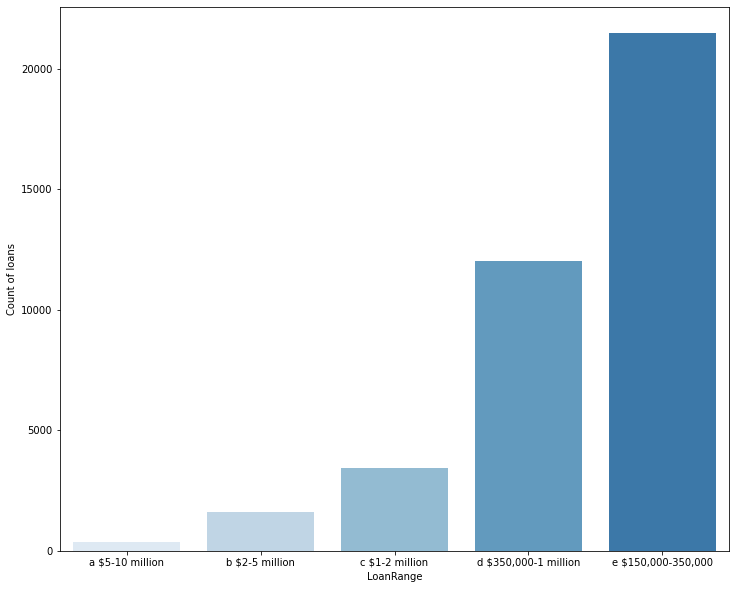

In [13]:
sns.set_palette(sns.color_palette("Blues"))
data = ppp_raw[ppp_raw['State'].isin(['IL','MO'])].groupby('LoanRange').count().reset_index()
plt.figure(figsize=(12, 10))
sns.barplot(x='LoanRange', y="Zip", data=data).set(ylabel = 'Count of loans')
plt.show()

Loans in the range of 150 to 350 thousand dollars are most frequent.  The amount of loans increase inversely with the value. Nothing surprising there.

In order to get this dataframe ready for analyse we need to assign a value to the loan size banding, group by zipcode and sum the loan amount.

In [14]:
ppp = ppp_raw[(ppp_raw['State'] == 'MO') | (ppp_raw['State'] == 'IL')][['LoanRange','Zip']].copy()

# Function to map amount
def amt_map(row):
  if row['LoanRange'] == 'a $5-10 million':
    return 7500
  elif row['LoanRange'] == 'b $2-5 million':
    return 3500 
  elif row['LoanRange'] == 'c $1-2 million':
    return 1500 
  elif row['LoanRange'] == 'd $350,000-1 million':
    return 775 
  else:
    return 250

# Apply function
ppp['loan_amount'] = ppp.apply(amt_map, axis=1)

ppp = ppp.groupby('Zip')['loan_amount'].sum().reset_index()

ppp.head()

,Zip,loan_amount
0,4459,1500
1,46375,250
2,46947,775
3,60002,18425
4,60004,77175


Lastly, we neem to put the zipcodes for Missouri and Illinois in a dataframe.  This will be used when get to extracting data from the **uszipcode** data api.

In [15]:
mo_il_zips = ppp_raw[ppp_raw['State'].isin(['IL','MO'])]['Zip'].unique()
mo_il_zips = pd.DataFrame(data=mo_il_zips, columns=['Zip'])
mo_il_zips['Zip'] = mo_il_zips['Zip'].astype(int)
mo_il_zips['Zip'] = mo_il_zips['Zip'].astype(str)
mo_il_zips = mo_il_zips.sort_values(['Zip'])
mo_il_zips.head()

,Zip
520,4459
938,46375
688,46947
431,60002
78,60004


### Moving to the **MIT Election Data**

This data is held at county level.  Fortunately [this](https://www.unitedstateszipcodes.org/zip-code-database/) website has a downloadable csv containing all US zipcodes, with the county in wich they reside.  I have saved this data to my google drive, and also to Github.

In [16]:
#zip_to_county_raw = pd.read_csv('gdrive/My Drive/zip_code_database.csv')
#zip_to_county_raw[zip_to_county_raw['state'] == 'IL'].head()

In [17]:
zip_to_county_raw = pd.read_csv('https://raw.githubusercontent.com/Brent-Morrison/Coursera_Capstone/master/zip_code_database.csv')
zip_to_county_raw[zip_to_county_raw['state'] == 'IL'].head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
26327,60001,PO BOX,0,Alden,NaN,NaN,IL,McHenry County,America/Chicago,NaN,NaN,US,42.45,-88.53,13
26328,60002,STANDARD,0,Antioch,"Old Mill Creek, Old Mill Crk",Wadsworth,IL,Lake County,America/Chicago,"224,847",NaN,US,42.47,-88.07,23150
26329,60004,STANDARD,0,Arlington Heights,Arlington Hts,NaN,IL,Cook County,America/Chicago,"847,224",NaN,US,42.09,-87.98,52270
26330,60005,STANDARD,0,Arlington Heights,Arlington Hts,NaN,IL,Cook County,America/Chicago,"224,630,708,773,847",NaN,US,42.06,-87.99,29710
26331,60006,PO BOX,0,Arlington Heights,Arlington Hts,NaN,IL,Cook County,America/Chicago,224,NaN,US,42.09,-87.98,204


The code below joins the zipcode details to the election data.

This results in a data frame (`elctn_county_zip`) containing the Democrat and Republican vote for each zipcode in Missouri and Illinois.  Note that the voting percentages are identical for each zipcode within a County.  

This is because the election results are held at County level.

In [18]:
# Reshape election data to return county level Democrat and Republican voting percentages
elctn_zip = elctn_county[elctn_county['state_po'].isin(['IL','MO'])][['state_po','county','party','candidatevotes']] \
  .pivot_table(index=['state_po','county'], columns='party', values='candidatevotes', aggfunc=np.sum, fill_value=0)
elctn_zip['dem_perc'] = elctn_zip['democrat'] / elctn_zip.sum(axis=1)
elctn_zip['rep_perc'] = elctn_zip['republican'] / elctn_zip.sum(axis=1)
elctn_zip = elctn_zip.filter(['dem_perc','rep_perc']).reset_index()

# Summarise the zip to county data
zip_to_county = zip_to_county_raw[zip_to_county_raw['state'].isin(['IL','MO'])][['state','county','zip','latitude','longitude','irs_estimated_population_2015']]
zip_to_county['county'] = zip_to_county['county'].str.replace(pat=' County', repl='')

# Join
elctn_county_zip = pd.merge(elctn_zip, zip_to_county, how='left', on='county')

# Since there are zipcodes across states, we need to drop duplicates
elctn_county_zip.drop_duplicates(subset='zip',inplace=True)

elctn_county_zip.head()

,state_po,county,dem_perc,rep_perc,state,zip,latitude,longitude,irs_estimated_population_2015
0,IL,Adams,0.263344,0.711595,IL,62301.0,39.93,-91.38,27280.0
1,IL,Adams,0.263344,0.711595,IL,62305.0,39.93,-91.34,18060.0
2,IL,Adams,0.263344,0.711595,IL,62306.0,39.93,-91.38,329.0
3,IL,Adams,0.263344,0.711595,IL,62320.0,40.03,-91.06,1990.0
4,IL,Adams,0.263344,0.711595,IL,62324.0,40.03,-90.95,1190.0


In [19]:
print('Total population of Illinois and Missouri:',elctn_county_zip['irs_estimated_population_2015'].sum())
print('Uniqueness test:',len(elctn_county_zip['zip'].unique()) / len(elctn_county_zip))

Total population of Illinois and Missouri: 15235846.0
Uniqueness test: 1.0


At this stage we note that we have circa 2,600 individual zip codes.  That is more than expected, and we may need to perform our analysis on a sample of these zip codes.  It would be surprising if Foursquare has data for this entire region.

### Turning now to the **demographic data**

This [SO answer](https://stackoverflow.com/questions/55011880/typeerror-zipcode-object-is-not-subscriptable) provides a nice helper to create a dataframe from the uszipcode query function.  

The data frame returned filters for zipcodes in the `mo_il_zips` created earlier.

In [20]:
query = (
  search.ses.query(
      SimpleZipcode.zipcode.label('zip'),
      SimpleZipcode.major_city.label('city'),
      SimpleZipcode.county.label('county'),
      SimpleZipcode.state.label('state'),
      SimpleZipcode.lat.label('lat'),
      SimpleZipcode.lng.label('lng'),
      SimpleZipcode.population.label('population'),
      SimpleZipcode.population_density.label('population_density'),
      SimpleZipcode.median_home_value.label('median_home_value'),
      SimpleZipcode.median_household_income.label('median_household_income'),
      SimpleZipcode.housing_units.label('housing_units'),
      SimpleZipcode.occupied_housing_units.label('occupied_housing_units'),
      )
  .filter(SimpleZipcode.zipcode.in_(mo_il_zips['Zip'].dropna().unique()))
  ).selectable
demographics = pd.read_sql_query(query, search.ses.connection(), index_col='zip')
demographics['county'] = demographics['county'].str.replace(pat=' County', repl='')
demographics.index = demographics.index.astype('int64')
demographics.shape

(1553, 11)

In [21]:
demographics.head()

,city,county,state,lat,lng,population,population_density,median_home_value,median_household_income,housing_units,occupied_housing_units
zip,,,,,,,,,,,
46375,Schererville,Lake,IN,41.49,-87.44,23820.0,1758.0,213800.0,74276.0,9984.0,9600.0
46947,Logansport,Cass,IN,40.70,-86.40,28866.0,156.0,75100.0,38946.0,12130.0,10901.0
60002,Antioch,Lake,IL,42.50,-88.10,24299.0,745.0,219600.0,78250.0,10548.0,9153.0
60004,Arlington Heights,Cook,IL,42.11,-87.98,50582.0,4564.0,332700.0,79892.0,21177.0,20013.0
60005,Arlington Heights,Cook,IL,42.06,-87.98,29308.0,4470.0,293300.0,69484.0,13484.0,12635.0


Lets check that the zip index is unique.  The snippet below divides the unique index values by the length of the dataframe, hence a value of 1 represents uniqueness.

In [22]:
 # Check uniqueness of index
len(demographics.index.get_level_values('zip').unique()) / len(demographics) 

1.0

### Bringing it together

We now have three data frames at the zipcode level.
1. `ppp` - containing the loan amount
2. `elctn_county_zip` - containing election results
3. `demographics` - containing the demographic data

It's time to join these together.

In [23]:
#Set indexes for joining

# Zip to index
ppp.set_index('Zip', inplace=True)

# Zip to index, with a bit of messing
elctn_county_zip['zip'] = elctn_county_zip['zip'].fillna(0)
elctn_county_zip['zip'] = elctn_county_zip['zip'].astype('int64')
elctn_county_zip.set_index('zip', inplace=True)

In [24]:
# Check the index types
print('ppp data frame index type:', ppp.index.get_level_values(0).dtype)
print()
print('elctn_county_zip data frame index type:', elctn_county_zip.index.get_level_values(0).dtype)
print()
print('demographics data frame index type:', demographics.index.get_level_values(0).dtype)

ppp data frame index type: int64

elctn_county_zip data frame index type: int64

demographics data frame index type: int64


In [25]:
# Join loan and demographic data
loan_elctn_demo = ppp.join(demographics)

In [26]:
# Join loan, demographics and election data
loan_elctn_demo = loan_elctn_demo.join(elctn_county_zip, rsuffix='_elctn')

In [27]:
loan_elctn_demo.shape

(1554, 20)

In [28]:
loan_elctn_demo.head()

,loan_amount,city,county,state,lat,lng,population,population_density,median_home_value,median_household_income,housing_units,occupied_housing_units,state_po,county_elctn,dem_perc,rep_perc,state_elctn,latitude,longitude,irs_estimated_population_2015
Zip,,,,,,,,,,,,,,,,,,,,
4459,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46375,250,Schererville,Lake,IN,41.49,-87.44,23820.0,1758.0,213800.0,74276.0,9984.0,9600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46947,775,Logansport,Cass,IN,40.70,-86.40,28866.0,156.0,75100.0,38946.0,12130.0,10901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60002,18425,Antioch,Lake,IL,42.50,-88.10,24299.0,745.0,219600.0,78250.0,10548.0,9153.0,IL,Lake,0.576495,0.402627,IL,42.47,-88.07,23150.0
60004,77175,Arlington Heights,Cook,IL,42.11,-87.98,50582.0,4564.0,332700.0,79892.0,21177.0,20013.0,IL,Cook,0.782682,0.196504,IL,42.09,-87.98,52270.0


### Re-shaping the loan, election and demographic data

The data frame above requires further manipulation, we need to:

1. Create a binary indicator for political persuasion `party`
2. Select only the required column
3. Remove rows with NaN's  
 


In [29]:
# Function to map amount
def party(row):
  if row['dem_perc'] > .6:
    return 'dem'
  elif row['rep_perc'] > .6:
    return 'rep'
  else:
    return 'other'

# Apply function
loan_elctn_demo['party'] = loan_elctn_demo.apply(party, axis=1)
loan_elctn_demo['perc_occ_housing_units'] = loan_elctn_demo['occupied_housing_units'] / loan_elctn_demo['housing_units']
loan_elctn_demo_smmry = loan_elctn_demo[['party','state','loan_amount','lat','lng','population','population_density','perc_occ_housing_units','median_home_value','median_household_income']].copy()
loan_elctn_demo_smmry.dropna(axis=0, how='any', inplace=True)
loan_elctn_demo_smmry.shape

(1454, 10)

In [30]:
loan_elctn_demo_smmry.head()

,party,state,loan_amount,lat,lng,population,population_density,perc_occ_housing_units,median_home_value,median_household_income
Zip,,,,,,,,,,
46375,other,IN,250,41.49,-87.44,23820.0,1758.0,0.961538,213800.0,74276.0
46947,other,IN,775,40.70,-86.40,28866.0,156.0,0.898681,75100.0,38946.0
60002,other,IL,18425,42.50,-88.10,24299.0,745.0,0.867747,219600.0,78250.0
60004,dem,IL,77175,42.11,-87.98,50582.0,4564.0,0.945035,332700.0,79892.0
60005,dem,IL,108550,42.06,-87.98,29308.0,4470.0,0.937036,293300.0,69484.0


Our data set contains nearly 1,500 zipcodes.  The Foursquare free api is not going to return that level of requests.  We will need to compress our sample. 

We will select the top 20 zipcodes by state and political party by population.



In [31]:
loan_elctn_demo_sample = loan_elctn_demo_smmry.reset_index(level=0, inplace=True)
loan_elctn_demo_sample = loan_elctn_demo_smmry[loan_elctn_demo_smmry['party'].isin(['dem','rep'])].groupby(['party','state']).apply(lambda x: x.nlargest(20,'population')).reset_index(drop=True).copy()
loan_elctn_demo_sample.shape

(80, 11)

In [32]:
loan_elctn_demo_sample.head()

,Zip,party,state,loan_amount,lat,lng,population,population_density,perc_occ_housing_units,median_home_value,median_household_income
0,60629,dem,IL,21750,41.78,-87.70,113916.0,16726.0,0.885706,159700.0,40650.0
1,60623,dem,IL,47000,41.84,-87.72,92108.0,17196.0,0.832110,155600.0,28949.0
2,60618,dem,IL,77800,41.95,-87.70,92084.0,18195.0,0.895314,336300.0,55577.0
3,60632,dem,IL,108625,41.82,-87.69,91326.0,12297.0,0.890453,177800.0,38545.0
4,60639,dem,IL,56575,41.92,-87.76,90407.0,18537.0,0.894050,206800.0,38707.0


### Foursquare data

The cell below contains the earlier defined function that grabs the Foursquare data.  

Earlier iterations of this notebook have saved the output of this function to a csv in my google drive account.  The data was saved in this manner due to volatility in the results returned by the Foursquare api. 

In [33]:
# For control logic.  
# - 'drive' to extract from drive csv, 
# - 'fsq' to use Foursquare api directly

source = 'drive'

In [34]:
if source == 'drive':
  fsq_raw = pd.read_csv('gdrive/My Drive/fsq2.csv')
else:
  fsq_raw = getNearbyVenues(
    names=loan_elctn_demo_sample['Zip'],
    latitudes=loan_elctn_demo_sample['lat'],
    longitudes=loan_elctn_demo_sample['lng']
  )
  fsq_raw.to_csv('gdrive/My Drive/fsq3.csv')


The resultant data frame.

In [35]:
fsq_raw.head()

,Unnamed: 0,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,60629,41.78,-87.7,Quality Beauty Supply,41.779010,-87.704119,Cosmetics Shop
1,1,60629,41.78,-87.7,Pepe's Mexican Restaurant,41.778816,-87.704435,Mexican Restaurant
2,2,60629,41.78,-87.7,7-Eleven,41.782835,-87.702767,Convenience Store
3,3,60629,41.78,-87.7,Walgreens,41.778249,-87.702817,Pharmacy
4,4,60629,41.78,-87.7,Dollar General,41.780620,-87.702855,Discount Store


In [36]:
fsq_raw.shape

(632, 8)

In [37]:
print('Number of zipcodes:', fsq_raw['Zip'].nunique())
print('Data frame length:', len(fsq_raw))

Number of zipcodes: 52
Data frame length: 632


It turns out Foursquare does not have data for 38 of the 80 zipcodes.  We do not have the option of sourcing a similar data set from a different source and must proceed.  

We will workaround this problem by imputing the mode, or the most frequently occuring venue, for each zipcode.  More on this below.

### Re-shaping the Foursquare data

The Venue Category returned by Foursquare is very detailed.  We will roll this up to more summarised level to describe the zipcodes. This roll-up can be performed with the Foursquare category hierarchy. 

Foursquare provides the hierarchy of categories in json format.  This is retrieved below.

In [38]:
ctgy_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
ctgy_url

'https://api.foursquare.com/v2/venues/categories?&client_id=0M35HSSAZ1L2QPGP5LAKSPMBUUDTERESBKXLNZRQMUCEVJYS&client_secret=QWIGICNR1KXB3RU5Y5LRJFH03RANUYOVRKNTUTO0KCONHAGQ&v=20200623'

In [39]:
ctgy_results = requests.get(ctgy_url).json()

In [40]:
level_1 = []
level_2 = []
for f in ctgy_results['response']['categories']:
  for g in f['categories']:
    level_1.append(f['name'])
    level_2.append(g['name'])

In [41]:
fsq_hrchy = pd.DataFrame({'level_1':level_1, 'level_2':level_2})
fsq_hrchy.head()

,level_1,level_2
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium
2,Arts & Entertainment,Arcade
3,Arts & Entertainment,Art Gallery
4,Arts & Entertainment,Bowling Alley


How many level 1 categories are there and what are they?

In [42]:
print('Count of level_1 categories:', fsq_hrchy['level_1'].nunique())

Count of level_1 categories: 10


In [43]:
print(fsq_hrchy['level_1'].unique())

['Arts & Entertainment' 'College & University' 'Event' 'Food'
 'Nightlife Spot' 'Outdoors & Recreation' 'Professional & Other Places'
 'Residence' 'Shop & Service' 'Travel & Transport']


We now merge the raw venue and category level data.

In [44]:
fsq = fsq_raw.merge(fsq_hrchy, how='left', left_on='Venue Category', right_on='level_2').copy()
fsq.head()

,Unnamed: 0,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,level_1,level_2
0,0,60629,41.78,-87.7,Quality Beauty Supply,41.779010,-87.704119,Cosmetics Shop,Shop & Service,Cosmetics Shop
1,1,60629,41.78,-87.7,Pepe's Mexican Restaurant,41.778816,-87.704435,Mexican Restaurant,Food,Mexican Restaurant
2,2,60629,41.78,-87.7,7-Eleven,41.782835,-87.702767,Convenience Store,Shop & Service,Convenience Store
3,3,60629,41.78,-87.7,Walgreens,41.778249,-87.702817,Pharmacy,Shop & Service,Pharmacy
4,4,60629,41.78,-87.7,Dollar General,41.780620,-87.702855,Discount Store,Shop & Service,Discount Store


Before proceeding we need to check if there are `NaN`s returned.  This will be the case if the hierarchy data does not contain a complete list of venues.

In [45]:
print('Proportion of matches:', 1- fsq[fsq['level_1'].isnull()]['Venue Category'].count() / len(fsq_raw))

Proportion of matches: 0.7262658227848101


So we have circa 27% of venues un-matched in that they did not have an entry in the hierarchy data.  Let's take a look at the un-matched venues.

In [46]:
print(fsq[fsq['level_1'].isnull()]['Venue Category'].unique())

['Taco Place' 'Grocery Store' 'Tennis Court' 'Soccer Field' 'Skating Rink'
 'Gymnastics Gym' 'Chinese Restaurant' 'Sports Bar' 'Kids Store'
 'Sushi Restaurant' "Women's Store" 'Gym' 'Ice Cream Shop' 'Pie Shop'
 'Cocktail Bar' 'New American Restaurant' 'Street Art' 'Liquor Store'
 'Track' 'Yoga Studio' 'Dive Bar' 'Gym / Fitness Center' 'Baseball Field'
 'Beer Store' 'Korean Restaurant' 'Vietnamese Restaurant'
 'Arts & Entertainment' 'Shoe Store' 'Japanese Restaurant' 'Boutique'
 'South American Restaurant' 'Frozen Yogurt Shop' 'Thai Restaurant'
 'Tapas Restaurant' "Men's Store" 'Accessories Store' 'Farmers Market'
 'Cupcake Shop' 'Martial Arts Dojo' 'Karaoke Bar' 'Jazz Club'
 'Ethiopian Restaurant' 'Climbing Gym' 'Food' 'Dance Studio' 'Theater'
 'Church' 'Golf Course' 'Skate Park']


### Impute missing values
It will be the difficult to match these records to a nested json file.  These will therefore be filled with the most frequent category, the mode,  by zipcode.

In [47]:
fsq_imp = fsq.copy()
fsq_imp['level_1'] = fsq_imp.groupby('Zip')['level_1'].transform(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

print('Proportion of matches:', 1- fsq_imp[fsq_imp['level_1'].isnull()]['Venue Category'].count() / len(fsq_imp))
print('Number of zipcodes:', fsq_imp['Zip'].nunique())
print('Count of level_1 categories:', fsq_imp['level_1'].nunique())
print('Data frame length:', len(fsq_imp))

# A catch all for remaining NaN's
#fsq_imp.fillna(value = {'level_1': 'Food', 'level_2': 'Food'}, inplace=True)

Proportion of matches: 0.9936708860759493
Number of zipcodes: 52
Count of level_1 categories: 7
Data frame length: 632


In [48]:
fsq_imp.head()

,Unnamed: 0,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,level_1,level_2
0,0,60629,41.78,-87.7,Quality Beauty Supply,41.779010,-87.704119,Cosmetics Shop,Shop & Service,Cosmetics Shop
1,1,60629,41.78,-87.7,Pepe's Mexican Restaurant,41.778816,-87.704435,Mexican Restaurant,Food,Mexican Restaurant
2,2,60629,41.78,-87.7,7-Eleven,41.782835,-87.702767,Convenience Store,Shop & Service,Convenience Store
3,3,60629,41.78,-87.7,Walgreens,41.778249,-87.702817,Pharmacy,Shop & Service,Pharmacy
4,4,60629,41.78,-87.7,Dollar General,41.780620,-87.702855,Discount Store,Shop & Service,Discount Store


We now re-shape the data frame to represent the count of venues per category as a percent of the total per zipcode.  This data is then joined back to the election and demographic data.

In [49]:
# Pivot wider and calculate percentage frequency
fsq = fsq_imp.groupby(['Zip','level_1'])['level_2'].count().reset_index().pivot(index='Zip', columns='level_1', values='level_2').fillna(0)
fsq = fsq.div(fsq.sum(axis=1), axis=0)
fsq.head()

level_1,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Zip,,,,,,,
60608,0.000000,0.714286,0.047619,0.000000,0.0,0.190476,0.047619
60609,0.000000,0.428571,0.142857,0.071429,0.0,0.357143,0.000000
60614,0.081081,0.648649,0.000000,0.081081,0.0,0.189189,0.000000
60617,0.000000,0.466667,0.000000,0.000000,0.0,0.466667,0.066667
60618,0.000000,0.300000,0.050000,0.100000,0.0,0.550000,0.000000


In [50]:
# Joining Foursquare data to the loan, election and demographic data 
loan_elctn_demo_fsq = loan_elctn_demo_sample.merge(fsq, how='left', left_on='Zip', right_index=True).fillna(0).copy()
loan_elctn_demo_fsq.head()

,Zip,party,state,loan_amount,lat,lng,population,population_density,perc_occ_housing_units,median_home_value,median_household_income,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,60629,dem,IL,21750,41.78,-87.70,113916.0,16726.0,0.885706,159700.0,40650.0,0.0,0.533333,0.00,0.000000,0.0,0.466667,0.000000
1,60623,dem,IL,47000,41.84,-87.72,92108.0,17196.0,0.832110,155600.0,28949.0,0.0,0.687500,0.00,0.000000,0.0,0.187500,0.125000
2,60618,dem,IL,77800,41.95,-87.70,92084.0,18195.0,0.895314,336300.0,55577.0,0.0,0.300000,0.05,0.100000,0.0,0.550000,0.000000
3,60632,dem,IL,108625,41.82,-87.69,91326.0,12297.0,0.890453,177800.0,38545.0,0.0,0.583333,0.00,0.083333,0.0,0.250000,0.083333
4,60639,dem,IL,56575,41.92,-87.76,90407.0,18537.0,0.894050,206800.0,38707.0,0.0,0.600000,0.00,0.000000,0.0,0.200000,0.200000


### Scaling before clustering

At the outset we stated that we would "gather characteristics at zipcode level, and group zipcodes into similar regions".  We will do this grouping into zipcodes intosimilar regions using a hierarchical clustering model. In order to apply that model, we need to scale our variables.  

Scaling is required as the effect of certain attributes may dominate others should they have greater dispersion.  

In [51]:
cluster_df = loan_elctn_demo_fsq.drop(['Zip','party','state','loan_amount','lat','lng'], axis=1)
#col_list = ['population','population_density','perc_occ_housing_units','median_home_value','median_household_income']
min_max_scaler = MinMaxScaler()
#cluster_df[col_list] = min_max_scaler.fit_transform(cluster_df[col_list])
cluster_df = min_max_scaler.fit_transform(cluster_df)

### Hierarchical clustering

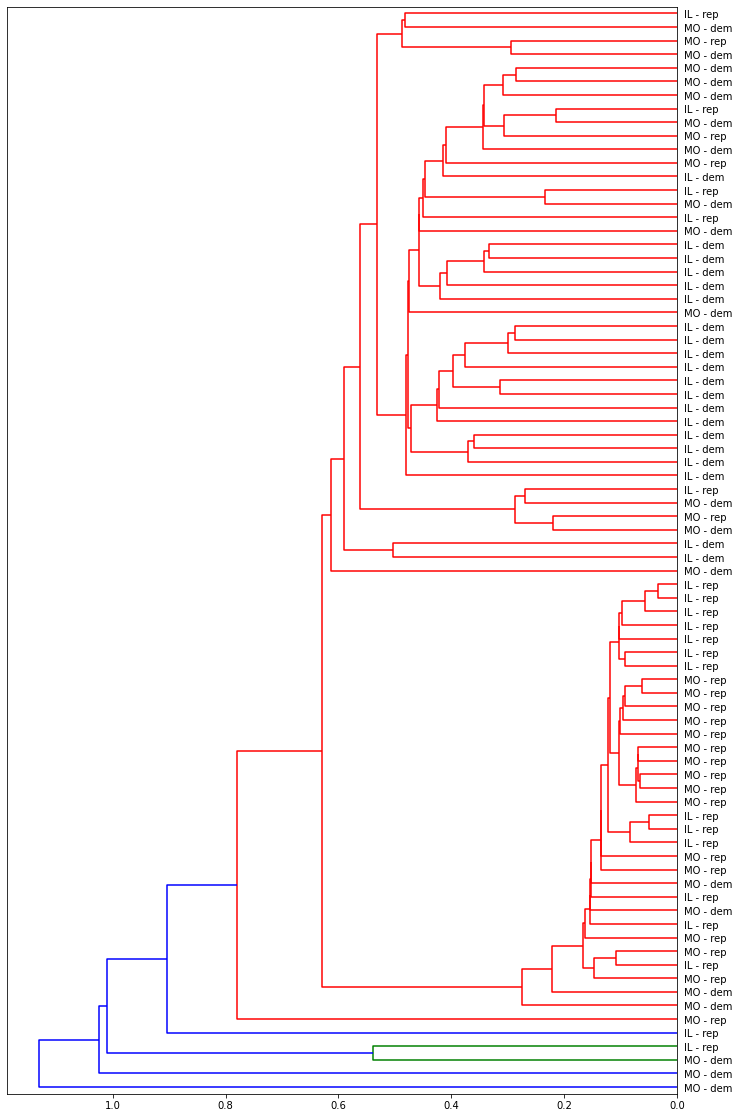

In [52]:
cluster_obj = linkage(cluster_df, 'single')

label_list = loan_elctn_demo_fsq['state'] +' - ' + loan_elctn_demo_fsq['party']# +' - ' + str(loan_elctn_demo_fsq['Zip'])
label_list = label_list.tolist()

plt.figure(figsize=(12, 20))
dendrogram(cluster_obj,
  leaf_font_size = 10,
  orientation='left',
  labels=label_list,
  distance_sort='descending',
  show_leaf_counts=False)
plt.show()

Lets look at cluster membership taking 8 clusters.

In [53]:
clusters = fcluster(cluster_obj,t=8,criterion='maxclust')
pd.Series(clusters).value_counts()

3    41
2    32
1     2
8     1
7     1
6     1
5     1
4     1
dtype: int64

Only two groups, clusters 2 and 3, contain 73 of the 80 zipcodes.  

Bring it all back together. 

In [54]:
cluster_result = loan_elctn_demo_fsq[['Zip','party','state','loan_amount','population']].copy()
cluster_result['loan_per_pop'] = cluster_result['loan_amount'] / cluster_result['population']
cluster_result['cluster'] = clusters
cluster_result.head()

,Zip,party,state,loan_amount,population,loan_per_pop,cluster
0,60629,dem,IL,21750,113916.0,0.190930,3
1,60623,dem,IL,47000,92108.0,0.510271,3
2,60618,dem,IL,77800,92084.0,0.844881,3
3,60632,dem,IL,108625,91326.0,1.189420,3
4,60639,dem,IL,56575,90407.0,0.625781,3


# Results

We will now inspect the distribution of loan values for the two clusters returning the vast majority of zipcodes.

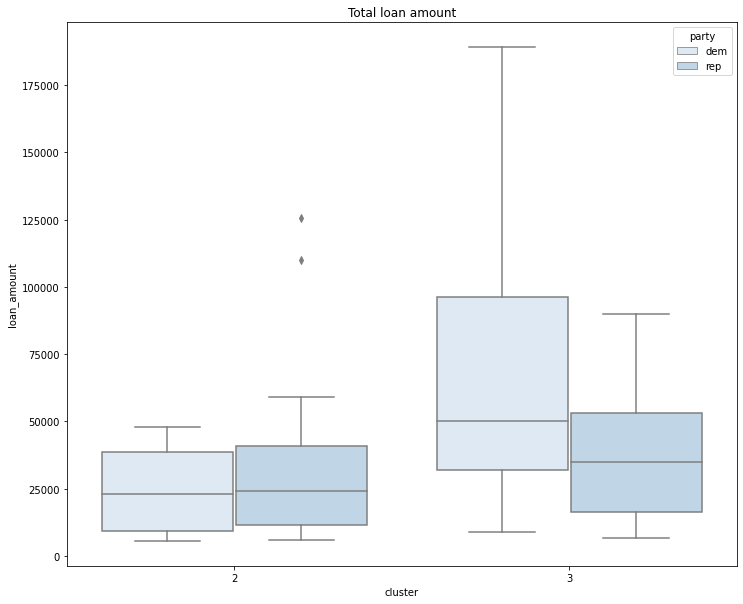

In [55]:
data = cluster_result[cluster_result['cluster'].isin(['2','3'])]
plt.figure(figsize=(12, 10))
sns.boxplot(x='cluster', hue='party', y='loan_amount', data=data).set(title = 'Total loan amount')
plt.show()

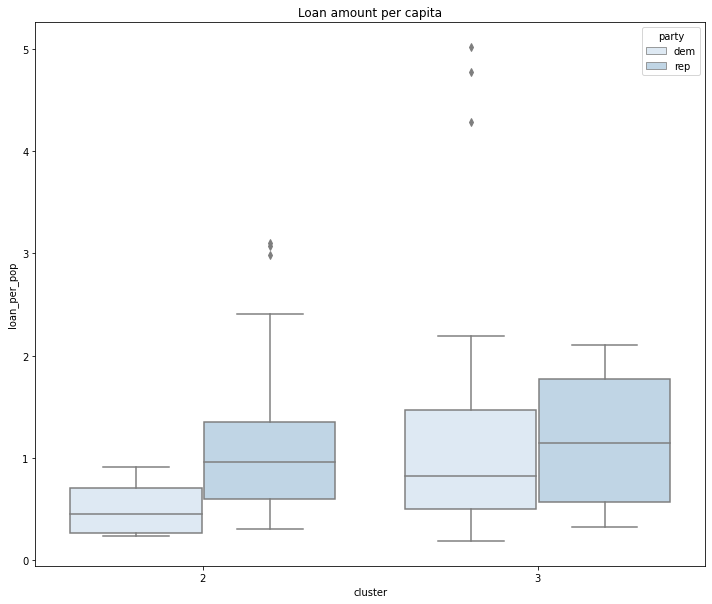

In [56]:
plt.figure(figsize=(12, 10))
sns.boxplot(x='cluster', hue='party', y='loan_per_pop', data=data).set(title = 'Loan amount per capita')
plt.show()

The box plots above represent the distribution of loan values (top) and value of loans per capita (bottom) for all zipcodes in each of the categories labelled 2 and 3.  The categories are clusters determined with reference to demographic and neighbourhood characteristics. 

These plots do not suggest a significant difference in loan uptake between Democrat (light) and Republican (dark) zipcodes.

# Discussion

A number of unrelated points on methodology and data (with the benefit of hindsight).

Ideally we should formally test for differences in means of the data presented in the box plots above. The results of an analysis of variance test would be informative in this regard.  Unfortunately deadlines loom (this report is being prepared for a Data Science course), and as a result of that we will rely only on the visual inspection referred to above.  

An interesting point to consider in light of the methodology used above is the fact that electoral results may be sufficiently close at zipcode to mask any underlying variation in the loan data.  

Reconsidering the question posed may have us regressing the count of loans over the count of all business establishments, on the percent of democrat or republican vote by zipcode.  This is beyond the scope of this analysis due to the lack of total business establishments data.

# Conclusion
This report set out to determine if political persuasion influences utilisation of government assistance, namely the uptake of loans issued under the Small Business Administration Paycheck Protection Program in the US.  

Ultimately the results were inconclusive.

 A number of things could have impacted the results.  Changing any of the items listed below may result in different and more robust results: 
 1. Greater coverage of Foursquare data
 2. A larger coverage of zipcodes
 3. Using electoral data at a more granular level
 4. Having access to total business establishment data

These items should be considered for further analysis.

# Appendix

Scratch work on nested json

In [57]:
n=8
m=31 #1,4 returns 3 results / 2 returns 2 results
print(ctgy_results['response']['categories'][n]['name'])
print(ctgy_results['response']['categories'][n]['categories'][m]['name'])
try:
  print(ctgy_results['response']['categories'][n]['categories'][m]['categories'][0]['name'])
except:
  print(ctgy_results['response']['categories'][n]['categories'][m]['name'])
try:
  print(ctgy_results['response']['categories'][n]['categories'][m]['categories'][0]['categories'][0]['name'])
except:
  try:
    print(ctgy_results['response']['categories'][n]['categories'][m]['categories'][0]['name'])
  except:
    print(ctgy_results['response']['categories'][n]['categories'][m]['name'])

Shop & Service
Cosmetics Shop
Cosmetics Shop
Cosmetics Shop
